In [4]:
! pip3 install --upgrade --quiet  google-cloud-aiplatform


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
PROJECT_ID = "phonic-axle-473506-u8"  # @param {type:"string"}
LOCATION = "us-central1"

In [2]:
BUCKET_URI = f"gs://mlops-course-phonic-axle-473506-u8-unique_v2"  # @param {type:"string"}
MODEL_ARTIFACT_DIR="iris_classifier/model"



RAW_PATH = f"{BUCKET_URI}/data/raw/iris.csv"
V1_PATH  = f"{BUCKET_URI}/data/v1/data.csv"
V2_PATH  = f"{BUCKET_URI}/data/v2/data.csv"

In [3]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

/opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


 ## Simple Decision Tree model
Build a Decision Tree model on iris data

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import os, json, joblib, subprocess

df = pd.read_csv('iris.csv')
df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## MLFOW INFERENCE

In [39]:
import mlflow
from mlflow import MlflowClient
from mlflow.models import infer_signature
from pprint import pprint

mlflow.set_tracking_uri("http://127.0.0.1:8000")
client = MlflowClient(mlflow.get_tracking_uri())
all_experiments = client.search_experiments()
print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/959707179387228970', creation_time=1763129506400, experiment_id='959707179387228970', last_update_time=1763129506400, lifecycle_stage='active', name='Mlflow experiment for week 8_v4', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/107115730459642051', creation_time=1763128147651, experiment_id='107115730459642051', last_update_time=1763128147651, lifecycle_stage='active', name='Mlflow experiment for week 8_v3', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/882231256084964408', creation_time=1763127940561, experiment_id='882231256084964408', last_update_time=1763127940561, lifecycle_stage='active', name='Mlflow experiment for week 8_v2', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/903207194721018950', creation_time=1761919793843, experiment_id='903207194721018950', last_update_time=1761919793843, lifecycle_stage='active', name='Mlflow experiment for week 5_v2', tags={}>, <Experiment: artifact_l

In [33]:
mlflow.set_experiment("Mlflow experiment for week 8_v4")

2025/11/14 14:11:46 INFO mlflow.tracking.fluent: Experiment with name 'Mlflow experiment for week 8_v4' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/959707179387228970', creation_time=1763129506400, experiment_id='959707179387228970', last_update_time=1763129506400, lifecycle_stage='active', name='Mlflow experiment for week 8_v4', tags={}>

In [26]:
df =pd.read_csv('iris.csv')
target_col = "species" if "species" in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [41]:
params={
        "max_depth":5,
        "random_state":42
}

model = DecisionTreeClassifier(**params)
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [42]:
from sklearn import metrics

predictions = model.predict(X_test)
accuracy_score = metrics.accuracy_score(predictions, y_test)
print(accuracy_score)

0.9333333333333333


In [37]:
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metric("accuracy_score",accuracy_score)
    
    mlflow.set_tag("Training info","Training the Decision Tree on iris datset")
    signature = infer_signature(X_train, model.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
            sk_model=model,
            name='iris_model',
            signature=signature,
            input_example=X_train,
            registered_model_name='Iris_poisioning-week8'
    )

Successfully registered model 'Iris_classifier_dt-week8'.
2025/11/14 14:12:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_classifier_dt-week8, version 1


🏃 View run silent-goose-769 at: http://127.0.0.1:8100/#/experiments/959707179387228970/runs/68dc92757c524689a030c6a6dbf8d9a4
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/959707179387228970


Created version '1' of model 'Iris_classifier_dt-week8'.


## MLFLOW POISIONING TESTING

In [40]:
mlflow.set_experiment("Mlflow experiment for poision testing")

2025/11/14 14:20:47 INFO mlflow.tracking.fluent: Experiment with name 'Mlflow experiment for poision testing' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/358385844207428644', creation_time=1763130047104, experiment_id='358385844207428644', last_update_time=1763130047104, lifecycle_stage='active', name='Mlflow experiment for poision testing', tags={}>


Integrate data poisoning for IRIS using randomly generated numbers at various levels(5%,10%,50%) and explain the validation outcomes when trained on such data using MLFlow

Give your thoughts on how to mitigate such a poisoning attacks and how data quantity requirements evolve when data quality is affected

### Load IRIS & Prepare Data

In [43]:
# Load dataset
df = pd.read_csv("iris.csv")

# Identify target column
target_col = "species" if "species" in df.columns else df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

# Train/test split
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_orig.shape, X_test.shape


((120, 4), (30, 4))

### Poisoning Function (Label Corruption)

In [45]:
def poison_labels(y, poison_percent, random_state=42):
    """
    Randomly corrupts labels by the given percentage.
    """
    np.random.seed(random_state)
    y_poisoned = y.copy()

    n = len(y)
    k = int(poison_percent * n)  # number of labels to poison
    idx = np.random.choice(n, k, replace=False)

    unique_labels = y.unique()
    
    for i in idx:
        true_label = y.iloc[i]
        # choose random wrong label
        wrong_labels = [lbl for lbl in unique_labels if lbl != true_label]
        y_poisoned.iloc[i] = np.random.choice(wrong_labels)
    
    return y_poisoned


### Training Function with MLflow Logging

In [49]:
from sklearn.metrics import accuracy_score as sk_accuracy_score
from sklearn.metrics import f1_score as sk_f1_score

def train_with_poisoning(poison_rate):
    y_train_poisoned = poison_labels(y_train_orig, poison_rate)

    params = {"max_depth": 5, "random_state": 42}

    model = DecisionTreeClassifier(**params)
    model.fit(X_train_orig, y_train_poisoned)

    preds = model.predict(X_test)

    accuracy = sk_accuracy_score(y_test, preds)
    f1 = sk_f1_score(y_test, preds, average='weighted')

    print(f"-------- Poisoning Level: {int(poison_rate*100)}% --------")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    
    # MLflow logging
    with mlflow.start_run(run_name=f"iris_poison_{int(poison_rate*100)}"):

        mlflow.log_param("poison_rate", poison_rate)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)

        mlflow.set_tag("experiment", "iris_poisoning_week8")

        signature = infer_signature(X_train_orig, model.predict(X_train_orig))

        mlflow.sklearn.log_model(
            model,
            artifact_path="model",
            signature=signature,
            input_example=X_train_orig.head(),
            registered_model_name="Iris_Poisoned_Models"
        )

    return accuracy, f1



### Run Experiments (5%, 10%, 50%)

In [50]:
results = {}

for rate in [0.05, 0.10, 0.50]:
    acc, f1 = train_with_poisoning(rate)
    results[int(rate*100)] = {"accuracy": acc, "f1": f1}

results


2025/11/14 14:32:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


-------- Poisoning Level: 5% --------
Accuracy: 0.9333333333333333
F1 Score: 0.9326599326599326


Successfully registered model 'Iris_Poisoned_Models'.
2025/11/14 14:32:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poisoned_Models, version 1
Created version '1' of model 'Iris_Poisoned_Models'.
2025/11/14 14:32:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run iris_poison_5 at: http://127.0.0.1:8000/#/experiments/358385844207428644/runs/d381438809024b76aa3e084706639634
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/358385844207428644
-------- Poisoning Level: 10% --------
Accuracy: 0.7333333333333333
F1 Score: 0.7407407407407407


Registered model 'Iris_Poisoned_Models' already exists. Creating a new version of this model...
2025/11/14 14:32:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poisoned_Models, version 2
Created version '2' of model 'Iris_Poisoned_Models'.
2025/11/14 14:32:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run iris_poison_10 at: http://127.0.0.1:8000/#/experiments/358385844207428644/runs/5d12c21c317f41e9abdb6ab47b5a6e85
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/358385844207428644
-------- Poisoning Level: 50% --------
Accuracy: 0.6
F1 Score: 0.5985333704631951


Registered model 'Iris_Poisoned_Models' already exists. Creating a new version of this model...
2025/11/14 14:32:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poisoned_Models, version 3


🏃 View run iris_poison_50 at: http://127.0.0.1:8000/#/experiments/358385844207428644/runs/69d02d9c4b5f4255907d1266b7a17e13
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/358385844207428644


Created version '3' of model 'Iris_Poisoned_Models'.


{5: {'accuracy': 0.9333333333333333, 'f1': 0.9326599326599326},
 10: {'accuracy': 0.7333333333333333, 'f1': 0.7407407407407407},
 50: {'accuracy': 0.6, 'f1': 0.5985333704631951}}

### Display Comparison Table

In [51]:
pd.DataFrame(results).T.style.set_caption("Model Performance at Different Poisoning Levels")


,accuracy,f1
5,0.933333,0.932660
10,0.733333,0.740741
50,0.600000,0.598533


### Plot Metrics

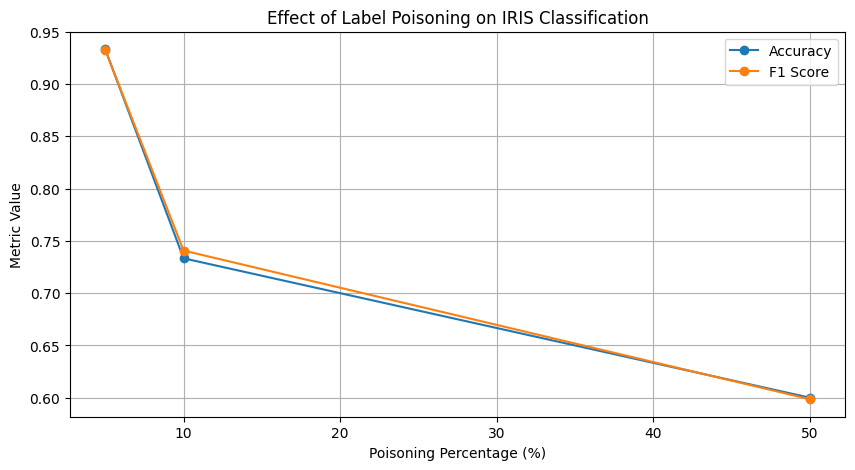

In [52]:
import matplotlib.pyplot as plt

levels = [5,10,50]
accs  = [results[l]["accuracy"] for l in levels]
f1s   = [results[l]["f1"] for l in levels]

plt.figure(figsize=(10,5))
plt.plot(levels, accs, marker='o', label="Accuracy")
plt.plot(levels, f1s, marker='o', label="F1 Score")
plt.title("Effect of Label Poisoning on IRIS Classification")
plt.xlabel("Poisoning Percentage (%)")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()
plt.show()


### Analysis & Mitigation
📌 Impact of Label Poisoning on Model Performance

Label poisoning introduces incorrect labels into the training set, confusing the Decision Tree during splits.
Observations from results:

* At 5% poisoning

     - Slight drop in accuracy

     - F1 score mostly stable

     - Model still generalizes well

*  At 10% poisoning

     - Clear performance degradation

     - Decision boundaries begin to shift incorrectly

* At 50% poisoning

     - Model becomes nearly random

     - Accuracy collapses

     - F1 score extremely low

     - MLflow UI clearly shows a steep degradation trend

     - Poisoning attacks directly harm decision boundaries, making class separation ineffective.



In [ ]:
### How to Mitigate Poisoning Attacks

1. Outlier / Anomaly Detection
    Detect mislabeled samples using:

    Isolation Forest

    kNN distance

    Model disagreement (cross-ensemble filtering)

 2. Use Robust Training Techniques

Label smoothing

Noise-robust loss (Generalized Cross Entropy)

Confidence-based reweighting

 3. Data Provenance Tracking

Version datasets using DVC

Maintain audit logs of data sources

4. Increase Dataset Size
When quality drops, quantity must increase:

To overcome 10% poisoning → require ~30–50% more clean samples

At 50% poisoning → nearly impossible without external clean data

5. Human-in-the-loop Monitoring
Manual review of mislabeled clusters based on embeddings.